## MNIST

In [1]:
import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_mldata
from sklearn.linear_model import SGDClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
mnist = fetch_mldata('MNIST original')
mnist

{'DESCR': 'mldata.org dataset: mnist-original',
 'COL_NAMES': ['label', 'data'],
 'target': array([0., 0., 0., ..., 9., 9., 9.]),
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

In [3]:
X, y = mnist['data'], mnist['target']

In [4]:
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

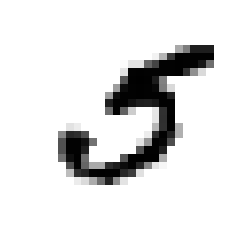

In [6]:
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show()

The MNIST dataset is actually already split into a training set (the first 60000 images) and a test set (the last 10000 images).

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [8]:
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## Training a Binary Classifier

In [9]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [10]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [11]:
sgd_clf.predict([some_digit])

array([ True])

## Performance Measures

### Measuring Accuracy Using Cross-Validation

In [12]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.96805, 0.96805, 0.96815])

In [13]:
# verify not-5 class
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [14]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.90875, 0.9091 , 0.9111 ])

### Confusion Matrix

In [15]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [16]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[54081,   498],
       [ 1417,  4004]])

### Precision and Recall

In [17]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8893824966681475

In [18]:
recall_score(y_train_5, y_train_pred)

0.7386091127098321

In [19]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.807014007860526

### Precision/Recall Tradeoff

In [20]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([152330.1133956])

In [21]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [22]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [23]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')
y_scores

array([-620070.75249834, -254322.6641994 , -529098.2103464 , ...,
       -479194.55034104, -918493.99959201, -314194.07770187])

In [24]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

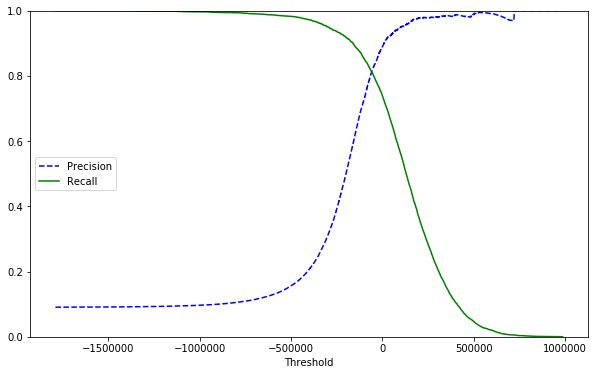

In [25]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.xlabel('Threshold')
    plt.legend(loc='center left')
    plt.ylim([0, 1])

plt.figure(figsize=(10, 6))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [26]:
y_train_90 = (y_scores > 70000) # 70000 comes from the plot above
precision_score(y_train_5, y_train_90)

0.9389420371412492

In [27]:
recall_score(y_train_5, y_train_90)

0.6155690831949825

### The ROC Curve

In [28]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

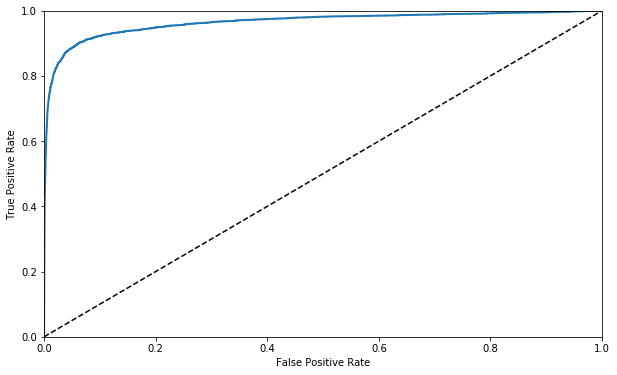

In [29]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plt.figure(figsize=(10, 6))
plot_roc_curve(fpr, tpr)
plt.show()

In [30]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.96421905133889

In [31]:
# compare Random Forest and SGD
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

In [32]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

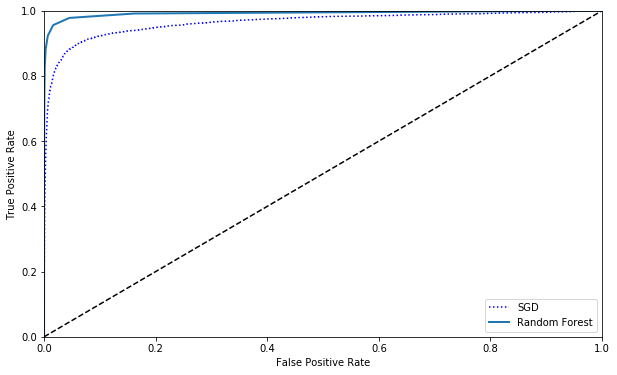

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend(loc='lower right')
plt.show()

In [34]:
roc_auc_score(y_train_5, y_scores_forest)

0.9919656037006097

## Multiclass Classification

In [35]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([5.])

In [36]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-317864.59769291, -462325.77336584, -543103.47870408,
        -350581.00282561, -460825.55831076,  152330.1133956 ,
        -585930.57582657, -342299.12993471, -678353.64236809,
        -624046.2639739 ]])

In [37]:
np.argmax(some_digit_scores)

5

In [38]:
sgd_clf.classes_

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [39]:
sgd_clf.classes_[5]

5.0

In [40]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5.])

In [41]:
len(ovo_clf.estimators_)

45

In [42]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5.])

In [43]:
forest_clf.predict_proba([some_digit])

array([[0.1, 0. , 0. , 0. , 0. , 0.9, 0. , 0. , 0. , 0. ]])

In [44]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.85177964, 0.84044202, 0.87308096])

In [45]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.85177964, 0.84044202, 0.87308096])